### Predicting transfer value of football players using ML (statistics and additional attributes)

In [28]:
# Importing relevant libaries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup, NavigableString, Tag
import os


In [29]:
#Specify relevant seasons and leagues
years = ['2015-2016','2016-2017','2017-2018','2018-2019','2019-2020','2020-2021','2021-2022']
leagues = ['spanish-la-liga','italian-serie-a','german-bundesliga','english-premier-league','rest-of-europe']
stats = ['stats_standard','stats_passing','stats_defense']

#Test
years_test = ['2017-2018','2018-2019']
leagues_test = ['english-premier-league']

In [30]:
def scrape(driver,id,stats):
    '''
    Sets up a function for scraping data based on a given driver

    args: driver (defines which driver to scrape from)
    '''

    soup = BeautifulSoup(driver.page_source, 'lxml')
    table_node = soup.find(id=id)

    columns_html = table_node.thead.find_all('th')
        # Extract the text
    columns = []
    for col in columns_html:
        columns.append(col.text)
    
    if stats == 'standard':
        columns = columns[7:]
    else:
        columns = columns[8:]


    rows_list = table_node.tbody.find_all('tr')

    data = []
    for row_node in rows_list:
        # if (rows_list.index(row_node) % 25 == 0):
        try:
            row = []
            for child in row_node.children:
                row.append(child.text)
            data.append(row)
        except:
            pass
    
    return columns, data

def clean_statistics(columns,data,period):
    df_out = pd.DataFrame(data,columns=columns)\
        .iloc[:,:-1]\
        .assign(Nation= lambda x: x['Nation'].str.split(' ').str[1],
            Pos = lambda x: x['Pos'].str.split(',').str[0], 
            Comp = lambda x: x['Comp'].str.split(None,1).str[1],
            # Pos = lambda x: pd.Categorical(x['Pos']),
            Squad = lambda x: pd.Categorical(x['Squad']),
            Year = period[0:4])
            # Nation = lambda x: pd.Categorical(x['Nation']))

    return df_out

In [ ]:
def get_standard_stats(periods):
    df_list = []
    for id in stats:
        id = id
        
        for period in periods:
            time.sleep(10)
            if id.split('_')[-1] == 'standard':
                url = f'https://fbref.com/en/comps/9/{period}/stats/{period}-Big-5-European-Leagues-Stats'
            else:
                id_ = id.split('_')[-1]
                f'https://fbref.com/en/comps/9/{period}/{id_}/{period}-Big-5-European-Leagues-Stats'

            driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
            driver.get(url)
            time.sleep(3)
            cookie = driver.find_element(By.CLASS_NAME,'qc-cmp2-summary-buttons').click()

            columns, data = scrape(driver,id)

            df_list.append(clean_statistics(columns, data, period))

        main_df = pd.concat(df_list)
        print(f'Number of observations in main dataset is: {len(main_df)}')
        return main_df


In [70]:
df_list = []
id = 'div_stats_passing'
url = 'https://fbref.com/en/comps/Big5/2017-2018/passing/players/2017-2018-Big-5-European-Leagues-Stats'
driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
driver.get(url)
time.sleep(3)
cookie = driver.find_element(By.CLASS_NAME,'qc-cmp2-summary-buttons').click()

soup = BeautifulSoup(driver.page_source, 'lxml')
table_node = soup.find(id=id)

columns_html = table_node.thead.find_all('th')
    # Extract the text
columns = []
for col in columns_html:
    columns.append(col.text)
# columns = columns[7:]

# rows_list = table_node.tbody.find_all('tr')

# data = []
# for row_node in rows_list:
#     # if (rows_list.index(row_node) % 25 == 0):
#     try:
#         row = []
#         for child in row_node.children:
#             row.append(child.text)
#         data.append(row)
#     except:
#         pass
# df_list.append(clean_statistics(columns, data, period))

# # time.sleep(10)

# main_df = pd.concat(df_list)
# print(f'Number of observations in main dataset is: {len(main_df)}')
# return main_df




<ipython-input-70-c8a855f69cfd>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver


In [73]:
columns[8:]

['Rk',
 'Player',
 'Nation',
 'Pos',
 'Squad',
 'Comp',
 'Age',
 'Born',
 '90s',
 'Cmp',
 'Att',
 'Cmp%',
 'TotDist',
 'PrgDist',
 'Cmp',
 'Att',
 'Cmp%',
 'Cmp',
 'Att',
 'Cmp%',
 'Cmp',
 'Att',
 'Cmp%',
 'Ast',
 'xA',
 'A-xA',
 'KP',
 '1/3',
 'PPA',
 'CrsPA',
 'Prog',
 'Matches']

In [5]:
df_stats['Year']= pd.to_datetime(df_stats['Year'], format='%Y')
df_stats['Year']= pd.DatetimeIndex(df_stats['Year']).year


In [6]:
def scrape_transferprice(driver,id):
    soup = BeautifulSoup(driver.page_source, 'lxml')
    table_node = soup.find(id=id)

    columns_html = table_node.thead.find_all('th')
        # Extract the text
    transfer_columns = []
    for col in columns_html:
        transfer_columns.append(col.text)

    rows_list = table_node.tbody.find_all('tr')

    transfer_data = []
    for row_node in rows_list:
        row = []
        for child in row_node.children:
            try:
                row.append(child.text)
            except:
                pass
        transfer_data.append(row)
    
    return transfer_columns, transfer_data

def clean_transfer(columns,data,period):    
    transfer_df = pd.DataFrame(data, columns=columns)\
                .assign(When = lambda x: x['When'].str.split(' ').str[0],
                    Price = lambda x: x['Price'].str.split('(?:(.*\d))?(?:([a-zA-Z]+))?').str[1],
                    Player = lambda x: x['Player'].str.rsplit(' ').str[:-1].apply(' '.join),
                    Year = int(period[0:4])-1)\
                .query("When != 'Jan'")\
                .replace(to_replace='None', value=np.nan).dropna()

    transfer_df.drop(transfer_df.columns[[0,1,4]],axis=1, inplace=True)


    return transfer_df                         

In [13]:
def get_transferprice(leagues,years):
    id = 'epl'
    df_transferprice = []
    for league in leagues:

        df_transferprice_ = []
        
        for periods in years:
            url = f'https://www.soccernews.com/soccer-transfers/{league}-transfers-{periods}/'
            driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
            driver.get(url)
            # time.sleep(3)
            # cookie = driver.find_element(By.ID,'cn-accept-cookie').click()
            
            # Get data
            columns_transfer, transfer_data = scrape_transferprice(driver,id)

            df_transferprice_.append(clean_transfer(columns_transfer,transfer_data,periods))
    
        df_transferprice.append(pd.concat(df_transferprice_))

    return pd.concat(df_transferprice)
#     main_transfer = pd.concat(df_transferprice)
#     print(f'Number of observations in main dataset is: {len(main_transfer)}')

#     return main_transfer

# main_transfer_df = get_transferprice(leagues_test,years)

In [14]:
df_transferprice = get_transferprice(leagues,years)

<ipython-input-13-3900a32a9103>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-13-3900a32a9103>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver


In [40]:
df_transferprice.to_csv('Transfer.csv')

In [43]:
df_transferprice['Year']= pd.to_datetime(df_transferprice['Year'], format='%Y')
df_transferprice['Year']= pd.DatetimeIndex(df_transferprice['Year']).year
df_transferprice.tail(10)

,Player,From,To,Price,Year
51,Marko Grujić,Liverpool,Porto,12,2020
53,Steven Berghuis,Feyenoord,Ajax,5.5,2020
55,Luan Peres,Santos,Marseille,4.5,2020
57,Calvin Stengs,AZ Alkmaar,Nice,15,2020
62,Ismail Jakobs,1. FC Koln,Monaco,6.5,2020
68,Achraf Hakimi,Inter Milan,PSG,60,2020
70,Loïc Badé,Lens,Rennes,20,2020
73,Jay Gorter,Go Ahead Eagles,Ajax,1,2020
76,Konrad de la Fuente,Barcelona,Marseille,3,2020
77,Danilo Pereira,FC Porto,PSG,16,2020


### Trying to merge transfer data with statistics

### **Hvis du har mod på det må du meget gerne kigge på dette, Carl Philip**

De to datasæt skal merges så vi ender med et samlet datasæt med stats og transferpris

In [19]:
test_stats_merge = stats_df.loc[stats_df['Player'] == 'Fabinho']

In [13]:
test_stats_merge

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,xG,npxG,xA,npxG+xA,xG,xA,xG+xA,npxG,npxG+xA,Year
778,779,Fabinho,BRA,MF,Monaco,Ligue 1,23,1993,34,34,...,5.4,2.4,3.8,6.2,0.16,0.11,0.27,0.07,0.18,2017
765,766,Fabinho,BRA,MF,Liverpool,Premier League,24,1993,28,21,...,0.8,0.8,1.3,2.1,0.04,0.06,0.09,0.04,0.09,2018


In [14]:
test_transfer_merge = df_transferprice.loc[df_transferprice['Player'] == 'Fabinho']

In [15]:
#test_transfer_merge = test_transfer_merge.iloc[0]

In [67]:
#new_df = test_stats_merge.merge(test_transfer_merge, how='left', left_on=['Player','Year'], right_on=['Price'])

new_df = df_stats.merge(df_transferprice, how='left', on=['Player','Year'])
new_df.dropna(subset=['Price'],inplace=True)

# Nu skal der bare droppes de rows med NaN i price

NameError: name 'df_stats' is not defined

In [66]:
new_df.tail(10)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,npxG+xA,xG,xA,xG+xA,npxG,npxG+xA,Year,From,To,Price
0,779,Fabinho,BRA,MF,Monaco,Ligue 1,23,1993,34,34,...,6.2,0.16,0.11,0.27,0.07,0.18,2017,AS Monaco,Liverpool,45


### Celle til leg med plots (Carl Philip)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2 and the array at index 1 has size 1

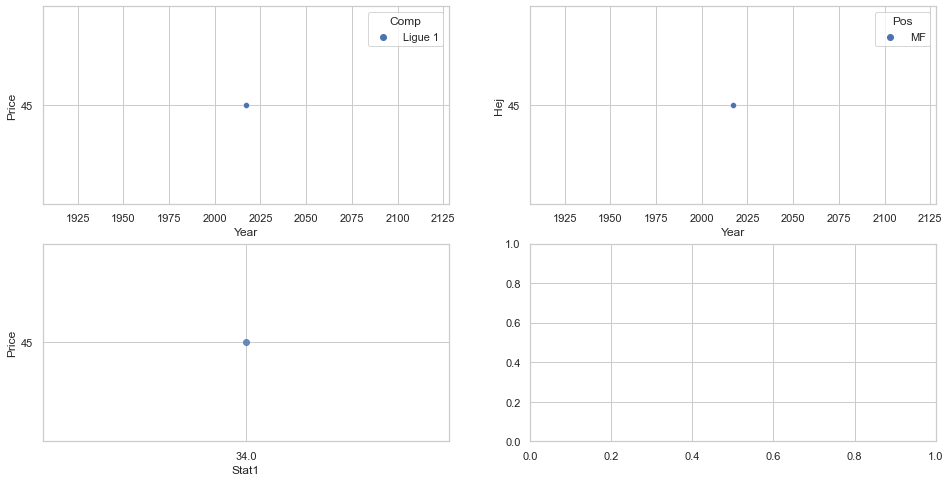

In [78]:
# Import graphical packages
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")


fp_figs = Path.cwd() / 'figs'  
# Use the Path object to actually create the subfolder
Path.mkdir(fp_figs, exist_ok=True)  

# 5
#f,ax = plt.subplots(2,2, figsize=(10,4))

f,ax = plt.subplots(2,2, figsize=(16,8))
sns.scatterplot(x='Year', y='Price', data=new_df, hue="Comp", ax=ax[0, 0]).set( xlabel = "Year", ylabel = "Price")
sns.scatterplot(x='Year', y='Price', data=new_df, hue="Pos", ax=ax[0, 1]).set( xlabel = "Year", ylabel = "Hej")

# Two figures with stats
sns.regplot(x='90s', y='Price', data=new_df, ax=ax[1, 0]).set( xlabel = "Stat1", ylabel = "Price")
sns.regplot(x='Gls', y='Price', data=new_df, ax=ax[1, 1]).set( xlabel = "Stat1", ylabel = "Price")

f.tight_layout()


#fig = plt.figure(figsize=(12,4))

#ax = fig.add_subplot(1,2,1)
#ax.scatter(x='Year', y='Price', data=new_df);
#ax.set_title('Distribution of m')

#
#ax = fig.add_subplot(1,2,2)
#ax.hist(h_vec3,bins=100,density=True,histtype='stepfilled');
#ax.set_title('Distribution of $h^*$')


#sns.boxplot(x='class', y='fare', data=titanic, ax=ax[1])


#ax = sns.regplot(y='petal_length', x='sepal_length', data=iris, order=2).set(title='Petal and Sepal length')
#plt.xlabel('Sepal length')
#plt.ylabel('Petal length')

plt.savefig('figs/pic1.png')


